In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UnifiedFlowNet(nn.Module):
    def __init__(self, latent_dim, cond_dim=None, drop_prob=0.1):
        """
        latent_dim: latent z 的通道数
        cond_dim: 如果 None，就和 latent_dim 相同；否则可用来添加其他条件（如标签维度）
        drop_prob: 进行无条件训练的概率 r
        """
        super().__init__()
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim or latent_dim
        self.drop_prob = drop_prob

        # 输入通道 = z_t + t_map + 条件 z_c
        in_ch = latent_dim + 1 + self.cond_dim
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),   nn.ReLU(),
            nn.Conv2d(64, latent_dim, 3, padding=1)
        )

    def forward(self, z_t, t, z_c=None):
        B, C, H, W = z_t.shape

        # 1) 时间通道
        t_map = t.view(B,1,1,1).expand(B,1,H,W)

        # 2) 条件通道：classifier-free guidance
        if z_c is None:
            # 强制无条件
            z_c_in = torch.zeros(B, self.cond_dim, H, W, device=z_t.device)
        else:
            # 以 drop_prob 随机丢弃
            mask = (torch.rand(B, device=z_t.device) < self.drop_prob).float()
            mask = mask.view(B,1,1,1)
            z_c_keep = z_c
            z_c_zero = torch.zeros_like(z_c)
            z_c_in = z_c_keep * (1-mask) + z_c_zero * mask

        # 拼接输入
        inp = torch.cat([z_t, t_map, z_c_in], dim=1)
        v_pred = self.net(inp)
        return v_pred

In [16]:
model = UnifiedFlowNet(latent_dim=16, cond_dim=16)

In [ ]:
for epoch in range(epochs):
    for imgs, _ in loader:
        # 编码
        z_data = vae.encode(imgs)            # [B,C,H,W]
        z_noise = torch.randn_like(z_data)   # 噪声端

        # 随机插值和 t
        t = torch.rand(B, device=device)
        z_t = (1-t_b)*z_data + t_b*z_noise
        v_true = z_noise - z_data

        # forward: 既可能是有条件，也可能是无条件
        v_pred = model(z_t, t, z_c=z_data)

        loss = F.mse_loss(v_pred, v_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
@torch.no_grad()
def sample(model, vae, mode='conditional', z_c=None, steps=20, batch_size=4):
    model.eval()
    latent_dim = model.latent_dim
    # 初始 z
    z = torch.randn(batch_size, latent_dim, H, W, device=device)
    # 如果 conditional 模式，z_c 必须给定；否则为 None
    z_c_input = z_c if mode=='conditional' else None

    for i in range(steps):
        t = 1.0 - i/steps
        t_vec = torch.full((batch_size,), t, device=device)
        v = model(z, t_vec, z_c=z_c_input)
        z = z - (1.0/steps) * v

    x_out = vae.decode(z).clamp(0,1)
    return x_out

In [4]:
import torch
device = 'cpu'

In [8]:
# 假设 z_data 与 z_noise 都是 [B, C, H, W]
z_data = torch.randn((2,16,32,32))           # [B,C,H,W]
B, C, H, W = z_data.shape
z_noise = torch.randn_like(z_data)   # 噪声端

# 1. 采样 t 并构造可广播的 t_b
t = torch.rand(B, device=device)               # [B]
t_b = t.view(B, 1, 1, 1)                       # [B,1,1,1]

# 2. 插值
z_t = (1.0 - t_b) * z_data + t_b * z_noise     # [B,C,H,W]

# 3. 真实速度场
v_true = z_noise - z_data                      # [B,C,H,W]

In [17]:
v_pred = model(z_t, t, z_c=z_data)

In [18]:
print(v_pred.shape)

torch.Size([2, 16, 32, 32])


In [10]:
print(v_true.shape)

torch.Size([2, 16, 32, 32])


In [13]:
B, C, H, W = z_t.shape
z_c = torch.randn((2,16,32,32))
cond_dim = 16
drop_prob = 0.5
# 1) 时间通道
t_map = t.view(B,1,1,1).expand(B,1,H,W)

# 2) 条件通道：classifier-free guidance
if z_c is None:
    # 强制无条件
    z_c_in = torch.zeros(B, cond_dim, H, W, device=z_t.device)
else:
    # 以 drop_prob 随机丢弃
    mask = (torch.rand(B, device=z_t.device) < drop_prob).float()
    mask = mask.view(B,1,1,1)
    z_c_keep = z_c
    z_c_zero = torch.zeros_like(z_c)
    z_c_in = z_c_keep * (1-mask) + z_c_zero * mask

# 拼接输入
inp = torch.cat([z_t, t_map, z_c_in], dim=1)

In [14]:
inp.shape

torch.Size([2, 33, 32, 32])

In [1]:
import os, json, wandb, torch
import numpy as np
import torch.nn.functional as F
from monai import transforms, data
from monai.data import DataLoader, DistributedSampler
from monai.utils import set_determinism
from tqdm import tqdm
from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import  PatchDiscriminator
import matplotlib.pyplot as plt
import torch.distributed as dist

[2025-05-04 03:39:48,199] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/envs/pytorch/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/opt/conda/envs/pytorch/compiler_compat/ld: warning: librt.so.1, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/opt/conda/envs/pytorch/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/opt/conda/envs/pytorch/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/opt/conda/envs/pytorch/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/opt/conda/envs/pytorch/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/opt/conda/envs/pytorch/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefi

In [ ]:
train_json_path = './json/train.json'
with open(train_json_path) as f:
    train_files = json.load(f)
val_json_path = './json/val.json'
with open(val_json_path) as f:
    val_files = json.load(f)
train_batchsize  = 1

transforms_1mm = transforms.Compose(
    [transforms.Spacingd(keys=["image"], pixdim=(1, 1, 1), mode=("bilinear")),
    transforms.Spacingd(keys=["brainmask"], pixdim=(1, 1, 1), mode=("nearest")),
    transforms.SpatialPadd(keys=["image","brainmask"], spatial_size=(160, 160, 128)),
    transforms.CropForegroundd(keys=["image"], source_key="brainmask",allow_smaller=False),
    transforms.DeleteItemsd(keys=["brainmask"]),
    transforms.RandSpatialCropd(keys=["image"], roi_size=(80, 80, 64),max_roi_size = (100, 100, 80), random_size=True),
    transforms.Resized(keys=["image"], spatial_size=(80, 80, 64), size_mode = 'all', mode='bilinear'),
    ]
)
transforms_2mm = transforms.Compose(
    [transforms.Spacingd(keys=["image"], pixdim=(2, 2, 2), mode=("bilinear")),
    transforms.Spacingd(keys=["brainmask"], pixdim=(2, 2, 2), mode=("nearest")),
    transforms.SpatialPadd(keys=["image","brainmask"], spatial_size=(80, 80, 64)),
    transforms.CropForegroundd(keys=["image"], source_key="brainmask",allow_smaller=False),
    transforms.DeleteItemsd(keys=["brainmask"]),
    transforms.Resized(keys=["image"], spatial_size=80, size_mode = 'longest', mode='bilinear'),
    transforms.CenterSpatialCropd(keys=["image"], roi_size=(80, 80, 64)),
    transforms.SpatialPadd(keys=["image"], spatial_size=(80, 80, 64)),
    ]
)
train_transforms = transforms.Compose(
    [
        transforms.CopyItemsd(keys=["image"], names=["path"]),
        transforms.LoadImaged(keys=["image","brainmask"]),
        transforms.EnsureChannelFirstd(keys=["image","brainmask"]),
        transforms.EnsureTyped(keys=["image","brainmask"]),
        transforms.Orientationd(keys=["image","brainmask"], axcodes="RAS"),
        # transforms.RandAffined(
        #     keys=["image","brainmask"],
        #     rotate_range=(-np.pi / 36, np.pi / 36),
        #     translate_range=(-1, 1),
        #     scale_range=(-0.05, 0.05),
        #     padding_mode="zeros",
        #     prob=0.5,
        # ),
        transforms.CropForegroundd(
            keys=["image", "brainmask"],
            source_key="brainmask",
            allow_smaller=False,
        ),
        transforms.ResizeWithPadOrCropd(keys=["image","brainmask"], spatial_size=(192, 192, 141)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0.5, upper=99.5, b_min=0, b_max=1,clip=True ),#, relative=True
        # transforms.OneOf([transforms_1mm, transforms_2mm]),
    ]
)
train_ds = data.Dataset(data=train_files, transform=train_transforms)
# sampler_train = DistributedSampler(train_ds, num_replicas=4, rank=rank)
train_loader = DataLoader(train_ds, batch_size=train_batchsize, shuffle=False, num_workers=8, persistent_workers=True, drop_last=True, sampler=None)

val_transforms = transforms.Compose(
    [
        transforms.CopyItemsd(keys=["image"], names=["path"]),
        transforms.LoadImaged(keys=["image","brainmask"]),
        transforms.EnsureChannelFirstd(keys=["image","brainmask"]),
        transforms.EnsureTyped(keys=["image","brainmask"]),
        transforms.Orientationd(keys=["image","brainmask"], axcodes="RAS"),
        transforms.CropForegroundd(
            keys=["image", "brainmask"],
            source_key="brainmask",
            allow_smaller=False,
        ),
        transforms.ResizeWithPadOrCropd(keys=["image","brainmask"], spatial_size=(192, 192, 141)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0.5, upper=99.5, b_min=0, b_max=1),
        # transforms_2mm,
    ]
)
val_ds = data.Dataset(data=val_files, transform=train_transforms)
# sampler_val = DistributedSampler(val_ds, num_replicas=4, rank=rank)
val_loader = DataLoader(val_ds, batch_size=train_batchsize, shuffle=False, num_workers=8, persistent_workers=True, drop_last=True, sampler=None)

In [1]:
import torch
from torch import nn
from diffusers import AutoencoderKLWan, WanTransformer3DModel
model_id = "Wan-AI/Wan2.1-T2V-14B-Diffusers"
vae = AutoencoderKLWan.from_pretrained(model_id, subfolder="vae", torch_dtype=torch.bfloat16, cache_dir="/working/cache/huggingface/hub")
vae = vae.to("cuda")
vae.eval()
transformer = WanTransformer3DModel.from_pretrained(model_id, subfolder="transformer", torch_dtype=torch.bfloat16, cache_dir="/working/cache/huggingface/hub")

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
class UnifiedFlowNet(nn.Module):
    def __init__(self, latent_dim, input_channels = 4,  drop_prob=0.1, lora = True):
        super().__init__()
        self.latent_dim = latent_dim
        self.input_channels = input_channels
        self.init_model(lora)

    def add_lora_to_model(self, model, lora_rank=4, lora_alpha=4, lora_target_modules="q,k,v,o,ffn.0,ffn.2", init_lora_weights="kaiming", pretrained_lora_path=None, state_dict_converter=None):
        # Add LoRA to UNet
        from peft import LoraConfig, inject_adapter_in_model
        lora_alpha = lora_alpha
        if init_lora_weights == "kaiming":
            init_lora_weights = True
            
        lora_config = LoraConfig(
            r=lora_rank,
            lora_alpha=lora_alpha,
            init_lora_weights=init_lora_weights,
            target_modules=lora_target_modules.split(","),
        )
        model = inject_adapter_in_model(lora_config, model)
        for param in model.parameters():
            # Upcast LoRA parameters into fp32
            if param.requires_grad:
                param.data = param.to(torch.float32)
        
    def init_model(self, lora):
        self.transformer = WanTransformer3DModel.from_pretrained(model_id, subfolder="transformer", torch_dtype=torch.bfloat16, cache_dir="/working/cache/huggingface/hub")
        old_patch_embed = self.transformer.patch_embedding
        new_patch_embed = nn.Conv3d(
            in_channels=old_patch_embed.in_channels*8,               # 修改为新输入通道
            out_channels=old_patch_embed.out_channels,
            kernel_size=old_patch_embed.kernel_size,
            stride=old_patch_embed.stride,
            padding=old_patch_embed.padding
        )
        self.transformer.patch_embedding = new_patch_embed
        old_proj_out = self.transformer.proj_out
        new_proj_out = nn.Linear(
            in_features=old_proj_out.in_features,
            out_features=old_proj_out.out_features*4,            # 修改为新输出通道
            bias=True
        )
        self.transformer.proj_out = new_proj_out
        if lora:
            self.transformer = self.add_lora_to_model(transformer, lora_rank=4, lora_alpha=4, lora_target_modules="to_q,to_k,to_v,to_out.0,linear_1,linear_2", init_lora_weights="kaiming", pretrained_lora_path=None, state_dict_converter=None)
    
    def forward(self, z_t, timestep, encoder_hidden_states=None, z_c=None):
        B, C, D, H, W = z_t.shape
        if encoder_hidden_states is not None:
            encoder_hidden_states = torch.zeros([1,256,4096], device=z_t.device)
        if z_c is None:
            z_c_in = torch.zeros_like(z_t, device=z_t.device, dtype=z_t.dtype)
        else:
            # 以 drop_prob 随机丢弃
            mask = (torch.rand(B,self.input_channels, device=z_t.device, dtype=z_t.dtype) < drop_prob).float()
            mask = mask.unsqueeze(2)
            mask = mask.repeat(1,1,self.latent_dim)
            mask = mask.view(B,self.latent_dim*self.input_channels,1,1,1)
            z_c_keep = z_c
            z_c_zero = torch.zeros_like(z_c, device=z_t.device, dtype=z_t.dtype)
            z_c_in = z_c_keep * (1-mask) + z_c_zero * mask

        # 拼接输入
        inp = torch.cat([z_t, z_c_in], dim=1)
        v_pred = self.transformer(inp, timestep, encoder_hidden_states)
        return v_pred


In [1]:
from flow_match import FlowMatchScheduler
scheduler = FlowMatchScheduler(shift=5, sigma_min=0.0, extra_one_step=True)
scheduler.set_timesteps(1000, training=True)

In [1]:
from flow_match import FlowMatchScheduler
scheduler = FlowMatchScheduler(shift=5, sigma_min=0.0, extra_one_step=True)
scheduler.set_timesteps(50, denoising_strength=1.0, shift=5.0)

In [7]:
from tqdm import tqdm
import torch

In [11]:
list_time = []
for progress_id, timestep in enumerate(tqdm(scheduler.timesteps)):
    print(timestep)
    list_time.append(timestep.item())
    # timestep_id = torch.argmin((scheduler.timesteps - timestep).abs())
    # sigma = scheduler.sigmas[timestep_id]
    # sigma_ = scheduler.sigmas[timestep_id + 1]
    # print((sigma_ - sigma))
    # print(progress_id, timestep, scheduler.timesteps[progress_id])

100%|██████████| 50/50 [00:00<00:00, 4284.10it/s]

tensor(1000.)
tensor(995.9349)
tensor(991.7355)
tensor(987.3949)
tensor(982.9059)
tensor(978.2609)
tensor(973.4514)
tensor(968.4685)
tensor(963.3028)
tensor(957.9440)
tensor(952.3810)
tensor(946.6020)
tensor(940.5941)
tensor(934.3434)
tensor(927.8350)
tensor(921.0526)
tensor(913.9785)
tensor(906.5934)
tensor(898.8763)
tensor(890.8046)
tensor(882.3529)
tensor(873.4940)
tensor(864.1975)
tensor(854.4304)
tensor(844.1558)
tensor(833.3333)
tensor(821.9177)
tensor(809.8591)
tensor(797.1015)
tensor(783.5821)
tensor(769.2307)
tensor(753.9683)
tensor(737.7049)
tensor(720.3389)
tensor(701.7543)
tensor(681.8182)
tensor(660.3774)
tensor(637.2549)
tensor(612.2449)
tensor(585.1064)
tensor(555.5555)
tensor(523.2557)
tensor(487.8049)
tensor(448.7180)
tensor(405.4054)
tensor(357.1428)
tensor(303.0303)
tensor(241.9355)
tensor(172.4138)
tensor(92.5926)


Text(0, 0.5, 'sigma')

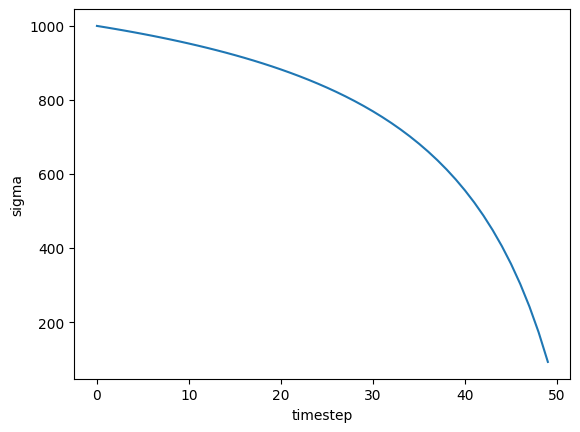

In [12]:
import matplotlib.pyplot as plt
plt.plot(list_time)
plt.xlabel('timestep')
plt.ylabel('sigma')

In [3]:
timestep_id = torch.randint(0, scheduler.num_train_timesteps, (1,))
print(timestep_id)
timestep = scheduler.timesteps[timestep_id]
print(timestep)

tensor([196])
tensor([953.5104])


In [4]:
latents = torch.randn((1, 16*8, 36, 24, 24), device="cuda")
noise = torch.randn_like(latents)

In [8]:
noisy_latents = scheduler.add_noise(latents, noise, timestep)
training_target = scheduler.training_target(latents, noise, timestep)
weight =scheduler.training_weight(timestep)
print(weight)

tensor(0.9535)
tensor(0.2967)


In [39]:
scheduler.num_train_timesteps

1000

In [3]:
old_patch_embed = transformer.patch_embedding
new_patch_embed = nn.Conv3d(
    in_channels=old_patch_embed.in_channels*8,               # 修改为新输入通道
    out_channels=old_patch_embed.out_channels,
    kernel_size=old_patch_embed.kernel_size,
    stride=old_patch_embed.stride,
    padding=old_patch_embed.padding
)
transformer.patch_embedding = new_patch_embed

In [4]:
old_proj_out = transformer.proj_out
new_proj_out = nn.Linear(
    in_features=old_proj_out.in_features,
    out_features=old_proj_out.out_features*4,            # 修改为新输出通道
    bias=True
)
transformer.proj_out = new_proj_out

In [ ]:
vae.eval()
for batch in train_loader:
    image = batch['image']
    mask = batch['brainmask']
    path = batch['path']
    image = image.permute(0, 1, 4, 2, 3)  # [B, C, H, W, D] -> [B, D, H, W, C]
    B, C, D, H, W  = image.shape
    image = image.view(B*C, D, H, W)  # [4, 1, D, H, W]
    image = image.unsqueeze(1)
    image = image.repeat(1, 3, 1, 1, 1)  # [4, 3, D, H, W]
    image = image.to(torch.bfloat16).to("cuda")
    with torch.no_grad():
        encode = vae.encode(image, return_dict=True)
    latent = encode.latent_dist.sample()
    latents = latent.view(B, 64, -1, int(H/8), int(W/8))

    noise = torch.randn_like(latents)

In [5]:
input_tensor = torch.randn(1, 16*8, 36, 24, 24)  # 示例输入
timestep = torch.tensor([0.5])  # 示例时间步
encoder_hidden_states = torch.zeros([1,256,4096])
device = "cuda:1"
input_tensor = input_tensor.to(torch.bfloat16).to(device)
timestep = timestep.to(torch.bfloat16).to(device)
encoder_hidden_states = encoder_hidden_states.to(torch.bfloat16).to(device)
transformer = transformer.to(torch.bfloat16).to(device)
transformer.eval()
with torch.no_grad():
    output_tensor = transformer(input_tensor,timestep,encoder_hidden_states)

In [36]:
import torch
drop_prob = 0.5
B=2
mask = (torch.rand(B,4) < drop_prob).float()
print(mask)
mask = mask.unsqueeze(2)
mask = mask.repeat(1, 1,16)
print(mask)
mask = mask.view(B,64,1,1,1)
temp = mask
print(mask.shape)
z_c = torch.randn(2, 16*4, 36, 24, 24)
z_t = torch.randn(2, 16*4, 36, 24, 24)
z_c_keep = z_c
z_c_zero = torch.zeros_like(z_c)
z_c_in = z_c_keep * (1-mask) + z_c_zero * mask
inp = torch.cat([z_t, z_c_in], dim=1)
print(inp.shape)

tensor([[1., 1., 0., 1.],
        [0., 0., 0., 0.]])
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
torch.Size([2, 64, 1, 1, 1])
torch.Size([2, 128, 36, 24, 24])


In [34]:
print(z_c_in[0,49,:,:,:])

tensor([[[ 0.4756,  1.3364, -1.8510,  ..., -0.2455,  0.8831, -2.2188],
         [ 1.6360,  0.2115,  0.1845,  ...,  0.4757,  0.5624,  0.9984],
         [-0.3493, -0.2139,  0.7961,  ...,  0.4748,  0.8761, -1.1175],
         ...,
         [-0.4544,  0.4924,  0.7404,  ...,  1.4657,  0.1157, -0.9766],
         [-1.6039, -1.0260,  0.9928,  ..., -2.1504,  0.1625,  0.3053],
         [-1.5007, -0.2203,  0.3625,  ...,  1.8407,  1.1935, -0.5810]],

        [[ 1.3024, -0.8282,  1.5123,  ...,  1.3112,  0.0914, -0.2439],
         [-1.0041,  0.6061, -0.7771,  ..., -2.1214, -1.2982, -0.7440],
         [ 0.2729, -1.5970, -0.9687,  ..., -0.9695,  1.0247, -0.6627],
         ...,
         [-0.4088, -0.6579,  1.1653,  ..., -2.5557,  1.0464, -0.2372],
         [-0.8993,  1.1056, -0.4442,  ...,  1.7403,  2.2419,  1.4537],
         [-1.3701,  0.5491,  0.4437,  ..., -1.0008,  0.8541,  0.8554]],

        [[-0.1559,  1.2950, -0.4012,  ..., -1.2270, -1.5531,  0.7714],
         [ 0.0904,  0.9392,  0.0465,  ..., -2

In [6]:
output_tensor.sample.shape

torch.Size([1, 64, 36, 24, 24])

In [ ]:
for batch in train_loader:
    image = batch['image']
    image = image.view(4, 1, 192, 192, 144)  # [4, 1, D, H, W]
    image = image.repeat(1, 3, 1, 1, 1)  # [4, 3, D, H, W]
    image = image.to(torch.bfloat16).to("cuda")
    with torch.no_grad():
        vae.eval()
        latent = vae.encode(image, return_dict=True).latent_dist.sample()

In [17]:
from peft import LoraConfig, inject_adapter_in_model
def add_lora_to_model(model, lora_rank=4, lora_alpha=4, lora_target_modules="q,k,v,o,ffn.0,ffn.2", init_lora_weights="kaiming", pretrained_lora_path=None, state_dict_converter=None):
    # Add LoRA to UNet
    lora_alpha = lora_alpha
    if init_lora_weights == "kaiming":
        init_lora_weights = True
        
    lora_config = LoraConfig(
        r=lora_rank,
        lora_alpha=lora_alpha,
        init_lora_weights=init_lora_weights,
        target_modules=lora_target_modules.split(","),
    )
    model = inject_adapter_in_model(lora_config, model)
    for param in model.parameters():
        # Upcast LoRA parameters into fp32
        if param.requires_grad:
            param.data = param.to(torch.float32)

In [18]:
transformer

WanTransformer3DModel(
  (rope): WanRotaryPosEmbed()
  (patch_embedding): Conv3d(128, 5120, kernel_size=(1, 2, 2), stride=(1, 2, 2))
  (condition_embedder): WanTimeTextImageEmbedding(
    (timesteps_proj): Timesteps()
    (time_embedder): TimestepEmbedding(
      (linear_1): lora.Linear(
        (base_layer): Linear(in_features=256, out_features=5120, bias=True)
        (lora_dropout): ModuleDict(
          (default): Identity()
        )
        (lora_A): ModuleDict(
          (default): Linear(in_features=256, out_features=4, bias=False)
        )
        (lora_B): ModuleDict(
          (default): Linear(in_features=4, out_features=5120, bias=False)
        )
        (lora_embedding_A): ParameterDict()
        (lora_embedding_B): ParameterDict()
        (lora_magnitude_vector): ModuleDict()
      )
      (act): SiLU()
      (linear_2): lora.Linear(
        (base_layer): Linear(in_features=5120, out_features=5120, bias=True)
        (lora_dropout): ModuleDict(
          (default): Ide

In [13]:
model = add_lora_to_model(transformer, lora_rank=4, lora_alpha=4, lora_target_modules="to_q,to_k,to_v,to_out.0,linear_1,linear_2", init_lora_weights="kaiming", pretrained_lora_path=None, state_dict_converter=None)

In [ ]:
latents = batch["latents"].to(self.device)
prompt_emb = batch["prompt_emb"]
prompt_emb["context"] = prompt_emb["context"][0].to(self.device)
image_emb = batch["image_emb"]
if "clip_feature" in image_emb:
    image_emb["clip_feature"] = image_emb["clip_feature"][0].to(self.device)
if "y" in image_emb:
    image_emb["y"] = image_emb["y"][0].to(self.device)

# Loss
self.pipe.device = self.device
noise = torch.randn_like(latents)
timestep_id = torch.randint(0, self.pipe.scheduler.num_train_timesteps, (1,))
timestep = self.pipe.scheduler.timesteps[timestep_id].to(dtype=self.pipe.torch_dtype, device=self.pipe.device)
extra_input = self.pipe.prepare_extra_input(latents)
noisy_latents = self.pipe.scheduler.add_noise(latents, noise, timestep)
training_target = self.pipe.scheduler.training_target(latents, noise, timestep)

# Compute loss
noise_pred = self.pipe.denoising_model()(
    noisy_latents, timestep=timestep, **prompt_emb, **extra_input, **image_emb,
    use_gradient_checkpointing=self.use_gradient_checkpointing,
    use_gradient_checkpointing_offload=self.use_gradient_checkpointing_offload
)
loss = torch.nn.functional.mse_loss(noise_pred.float(), training_target.float())
loss = loss * self.pipe.scheduler.training_weight(timestep)